In [1]:
from tqdm import tqdm, trange
import torch
import torchvision
from PIL import Image, ImageDraw
from torchvision import models
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imagesize
from torch.utils import data
import torch.optim as optim
from skimage import io, color
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import os
from pathlib import Path
from torch.utils.data import SubsetRandomSampler,DataLoader,Dataset
import cv2
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
np.random.seed(0)
torch.manual_seed(0)

/home/anshul/.conda/envs/py38torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_path = 'BreakHis/fold1_seperated_2_classes/test/100X/Malignant/SOB_M_DC-14-11520-100-002.png'
img = Image.open(img_path)

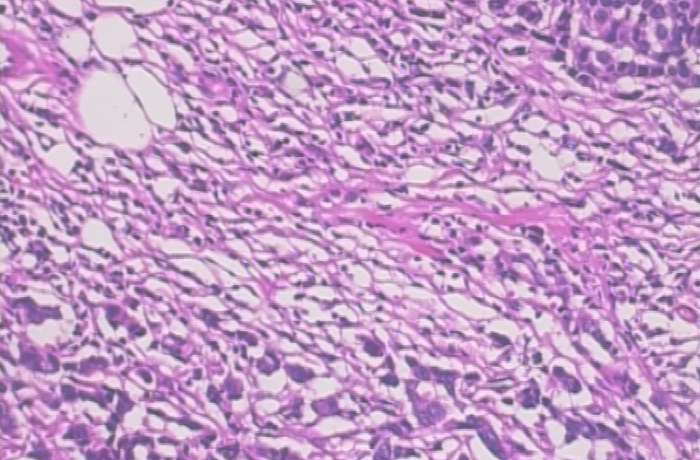

In [3]:
img

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
#data_path = 'BreakHis/fold1_seperated_2_classes/train/40X'
training_dataset_path = 'BreakHis/fold1_seperated_2_classes/train/40X'
testing_dataset_path = 'BreakHis/fold1_seperated_2_classes/test/40X'

In [6]:
def train_transform():
  transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean =  [0.8058, 0.6418, 0.7678],
    std = [0.0880, 0.1171, 0.0879])
    ])
  return transform

In [7]:
transform =  train_transform()

In [8]:
X = transform(img).unsqueeze_(0)

In [9]:
def load_dataset(path,transform_img):
  data = torchvision.datasets.ImageFolder(root=path, transform=transform)
  return data

In [10]:
training_dataset = load_dataset(training_dataset_path,transform)
training_dataset

Dataset ImageFolder
    Number of datapoints: 1250
    Root location: BreakHis/fold1_seperated_2_classes/train/40X
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.8058, 0.6418, 0.7678], std=[0.088, 0.1171, 0.0879])
           )

In [11]:
testing_dataset = load_dataset(testing_dataset_path,transform)
testing_dataset

Dataset ImageFolder
    Number of datapoints: 745
    Root location: BreakHis/fold1_seperated_2_classes/test/40X
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.8058, 0.6418, 0.7678], std=[0.088, 0.1171, 0.0879])
           )

In [12]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 16,shuffle=True)

In [13]:
#Splitting Testing Data into 30% Validation and 70% Testing
dataset_size = len(testing_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.3 * dataset_size))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
test_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx) 
test_loader = torch.utils.data.DataLoader(dataset = testing_dataset,batch_size = 16,sampler=test_sampler,shuffle=False)
val_loader = DataLoader(dataset= testing_dataset, shuffle=False, batch_size=16, sampler=val_sampler)

In [14]:
#model.classifier.out_features = 2

In [15]:
'''model = torchvision.models.swin_b()
out_features = 2
model.head = nn.Linear(in_features=1024,out_features=out_features)'''

'model = torchvision.models.swin_b()\nout_features = 2\nmodel.head = nn.Linear(in_features=1024,out_features=out_features)'

In [16]:
from transformers import SwinConfig, SwinModel
from transformers import AutoImageProcessor, SwinForImageClassification
configuration = SwinConfig()
model = SwinForImageClassification(configuration)

In [17]:
model.to(device)

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [18]:
model(X.to(device))

SwinImageClassifierOutput(loss=None, logits=tensor([[0.2254, 0.7429]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None, reshaped_hidden_states=None)

In [19]:
N_EPOCHS = 10
LR = 0.0001
optimizer = optim.SGD(model.parameters(), lr=LR,momentum=0.9)
criterion = CrossEntropyLoss()

In [20]:
def set_device():
  if torch.cuda.is_available():
    dev = 'cuda:0'
  else:
    dev = 'cpu'
  return torch.device(dev)

In [21]:
def train_nn(model, train_loader, test_loader,criterion,optimizer,n_epochs):
  device = set_device()
  best_acc = 0
  train_losses = []
  train_acc = []
  val_acc = []
  val_losses = []
  model = model.to(device)
  for epoch in range(n_epochs):
    print("Epoch number: %d"%(epoch+1))
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    for data in train_loader:
      images,labels = data
      images = images.to(device) #for faster processing
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad() #Set grad = 0 before back prop
      outputs = model(images)

      _,predicted = torch.max(outputs.logits,1)

      loss = criterion(outputs.logits,labels)
      loss.backward() #Calculate Weight gradients
      optimizer.step() #update weights
      running_loss += loss.item()
      running_correct += (labels==predicted).sum().item()
      
    

    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100.0*running_correct/total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)

    print("  -Training Dataset, Got %d out of %d images correctly (%0.3f%%). Epoch Loss: %0.3f"%(running_correct, total, epoch_acc,epoch_loss))
    test_dataset_acc, test_dataset_loss = evaluate_model(model,test_loader,criterion)
    val_acc.append(test_dataset_acc)
    val_losses.append(test_dataset_loss) 

    if (test_dataset_acc>best_acc):
        best_acc = test_dataset_acc
        save_checkpoint(model,epoch,optimizer,best_acc,train_losses, train_acc, val_losses,val_acc)

  print('Finished Training')
  return model,train_losses,train_acc,val_acc,val_losses

In [22]:
def save_checkpoint(model, epoch, optimizer, best_acc, train_losses, train_acc, val_losses, val_acc):
    state = {
        'epoch': epoch + 1,
        'model': model.state_dict(),
        'best accuracy': best_acc,
        'optimizer': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_acc': train_acc,
        'val_losses': val_losses,
        'val_acc': val_acc
    }
    torch.save(state, 'Models/swin_40_temp100epoch.pth')

In [23]:
def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0

    with torch.no_grad(): 
          for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0) 

            outputs = model(images)

            _,predicted = torch.max(outputs.logits,1)
            loss = criterion(outputs.logits,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))

    return epoch_acc,epoch_loss


In [24]:
#Train the model
#history, train_losses, train_acc, val_acc, val_losses = train_nn(model, train_loader,val_loader, criterion, optimizer,2)

In [25]:
'''from ptflops import get_model_complexity_info

# Define a function to compute FLOPS
def get_flops(model, input_size):
    flops, params = get_model_complexity_info(model, input_size, as_strings=True, print_per_layer_stat=True)
    print(f"FLOPs: {flops}")
    print(f"Parameters: {params}")

# Define the input size. Here, it's a single image with 3 channels and size 512x512
input_size = (3, 512, 512)

# Compute FLOPS for the ViTForImageClassification model
get_flops(model, input_size)'''

'from ptflops import get_model_complexity_info\n\n# Define a function to compute FLOPS\ndef get_flops(model, input_size):\n    flops, params = get_model_complexity_info(model, input_size, as_strings=True, print_per_layer_stat=True)\n    print(f"FLOPs: {flops}")\n    print(f"Parameters: {params}")\n\n# Define the input size. Here, it\'s a single image with 3 channels and size 512x512\ninput_size = (3, 512, 512)\n\n# Compute FLOPS for the ViTForImageClassification model\nget_flops(model, input_size)'

In [26]:
#def count_parameters(model):
    #return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [27]:
#total_params = count_parameters(model)
#print(f"Total number of parameters in the integrated model: {total_params}")

In [28]:
model_path = 'Models/swin_40_temp100epoch.pth'
check = torch.load(model_path)

In [29]:
check['best accuracy']

76.68161434977578

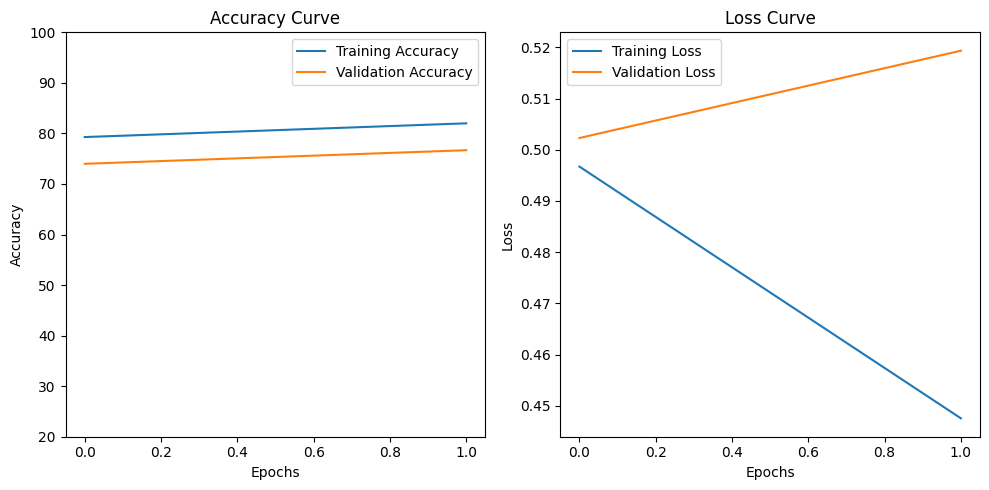

In [30]:
folder_path = 'Graphs/SwinTransformer_Combined/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.figure(figsize=(10, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(check['train_acc'], label='Training Accuracy')
plt.plot(check['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,100)
plt.title('Accuracy Curve')
plt.ylim(20, 100)  # Set y-axis limits from 0 to 100 for uniformity
plt.legend()
plt.savefig(os.path.join(folder_path, 'accuracy_curve_swin.png'))

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(check['train_losses'], label='Training Loss')
plt.plot(check['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(os.path.join(folder_path, 'loss_curve_vitAE.png'))

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'training_curves_swin.png'))

plt.show()

In [31]:
model.load_state_dict(check['model'])

<All keys matched successfully>

In [32]:
def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0

    with torch.no_grad():
          for data in tqdm(test_loader,desc='Evaluating'):
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _,predicted = torch.max(outputs.data,1)
            loss = criterion(outputs,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))

    return epoch_acc,epoch_loss

In [33]:
#evaluate_model(model,test_loader,criterion)    

In [34]:
#evaluate_model(model,train_loader,criterion)

In [35]:
def evaluate_model_classification_report(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            true_labels.extend(labels.cpu().numpy())

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted.cpu().numpy())

    return true_labels, predicted_labels

In [36]:
#true_labels, predicted_labels = evaluate_model_classification_report(model, test_loader)

In [37]:
#from sklearn.metrics import classification_report,roc_auc_score
#print(classification_report(true_labels, predicted_labels))

In [38]:
#auc_score = roc_auc_score(true_labels, predicted_labels)
#print("AUC Score:", auc_score)

Explainability

In [39]:
model.to(device)

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [40]:
img_path = 'CMT/Malignant/4X/5.JPG'
img = Image.open(img_path)
img = img.resize((512,512))
img_tensor = transform(img)

In [41]:
img = Image.open(img_path)
img = img.resize((512,512))
X = transform(img).unsqueeze_(0)
logits = model(X.to(device))

In [42]:
logits

SwinImageClassifierOutput(loss=None, logits=tensor([[-0.5189,  1.3559]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None, reshaped_hidden_states=None)

In [43]:
_,index = torch.max(logits.logits,dim=1)
classes = ['Benign','Malignant']
print(classes[index])

Malignant


Predicted class Malignant: 1.274061918258667
Image saved to gradcam_output_cv2.png


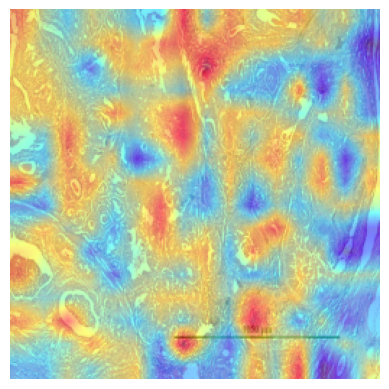

In [44]:
from transformers import SwinForImageClassification
from functools import partial
from typing import List, Callable, Optional
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAM

# Function to reshape tensor for Swin model
def swinT_reshape_transform_huggingface(tensor, width, height):
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

CATEGORY_NAMES = ["Benign", "Malignant"]

def category_name_to_index(model, category_name):
    return CATEGORY_NAMES.index(category_name)

class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

# Function to get the class with the highest probability
def print_top_categories(model, img_tensor):
    logits = model(img_tensor.unsqueeze(0)).logits
    benign_index = category_name_to_index(model, "Benign")
    malignant_index = category_name_to_index(model, "Malignant")
    
    relevant_logits = logits[0, [benign_index, malignant_index]]
    max_index = np.argmax(relevant_logits.cpu().detach().numpy())
    category = "Benign" if max_index == 0 else "Malignant"
    max_logit = relevant_logits[max_index].item()
    
    print(f"Predicted class {category}: {max_logit}")
    
    return max_index  # Return the index of the class with the maximum probability

# Model configuration and loading
configuration = SwinConfig()
model = SwinForImageClassification(configuration)
model_path = 'Models/swin_40_temp100epoch.pth'
check = torch.load(model_path)
model.load_state_dict(check['model'])
model.eval()

# Define target layer and reshape transform
target_layer = model.swin.layernorm
reshape_transform = partial(swinT_reshape_transform_huggingface, 
                            width=img_tensor.shape[2] // 32, 
                            height=img_tensor.shape[1] // 32)

# Classifier wrapper
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

# Function to run Grad-CAM on the class with the highest probability
def run_grad_cam_on_top_category(model: torch.nn.Module,
                                 target_layer: torch.nn.Module,
                                 img_tensor: torch.Tensor,
                                 img: Image,
                                 max_index: int,
                                 reshape_transform: Optional[Callable],
                                 method: Callable = GradCAM):
    # Create the target based on the maximum probability class
    target = [ClassifierOutputTarget(max_index)]
    
    # Run Grad-CAM for the top category
    with method(model=HuggingfaceToTensorModelWrapper(model),
                target_layers=[target_layer],
                reshape_transform=reshape_transform) as cam:
        grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=target)[0]
        
        # Create visualization
        visualization = show_cam_on_image(np.float32(img) / 255, grayscale_cam, use_rgb=True)
        visualization = cv2.resize(visualization, (visualization.shape[1] // 2, visualization.shape[0] // 2))
        return visualization

# Save the image using OpenCV's cv2.imwrite
def save_image_opencv(image: np.ndarray, save_path: str):
    # Convert image from RGB to BGR (since OpenCV expects BGR format)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, image_bgr)
    print(f"Image saved to {save_path}")

# Display using OpenCV for 10 seconds
def display_image_opencv(image: np.ndarray, display_time=10000):
    # Convert image from RGB (PIL format) to BGR (OpenCV format)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imshow("Grad-CAM Output", image_bgr)
    cv2.waitKey(display_time)  # Display for `display_time` milliseconds (10 seconds = 10000 ms)
    cv2.destroyAllWindows()

# Plot image using matplotlib
def plot_image(image: np.ndarray):
    plt.imshow(image)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

# Example usage:
# First, get the top category (Benign or Malignant)
max_index = print_top_categories(model, img_tensor)

# Then, run Grad-CAM only on that top category
gradcam_image = run_grad_cam_on_top_category(model=model,
                                             target_layer=target_layer,
                                             img_tensor=img_tensor,
                                             img=img,
                                             max_index=max_index,
                                             reshape_transform=reshape_transform)

# Define the save path and save the image using OpenCV
save_path = "gradcam_output_cv2.png"
save_image_opencv(gradcam_image, save_path)

# Display the image using OpenCV for 10 seconds
display_image_opencv(gradcam_image, display_time=10000)

# Display the image as a figure using matplotlib
plot_image(gradcam_image)
